## Note to Self: Need to Make Classification Model (with Bert PyTorch? probably most impressive) and also Improve NER Model (more Gold Standard Inputs (10) using 

In [1]:
import pandas as pd, spacy, random
from IPython.display import display, Image
import re
from re import sub
from dateutil import parser
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ArmorDoc_Challenge/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load your training data here.

In [2]:
page_df = pd.read_csv('./data/extracted_data.csv',index_col=0)

In [3]:
page_df.head()

,page_number,image_file_names,image_file_paths,text
0,0,page0.png,/data/png_images/page0.png,\n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY C...
1,1,page1.png,/data/png_images/page1.png,ADJUSTABLE RATE NOTE\n\n(HOME EQUITY CONVERSIO...
2,2,page2.png,/data/png_images/page2.png,ADJUSTABLE RATE SECOND NOTE\n\n(HOME EQUITY CO...
3,3,page3.png,/data/png_images/page3.png,\n\napSOsTaBLe RATE SECONDSOTE\n(HOME EQUITY ...
4,4,page4.png,/data/png_images/page4.png,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n(HOME E...


## Extracting Data with Regular Expressions

### Extracting Document Label Variable

In [4]:
all_pages = page_df.text

In [5]:
note_type_list = []

for page in all_pages:
  note_type = 'missing'
  # checking if the term "second note" is in the first 100 characters:
  if "second note" in page[:100].lower():
  # checking if the term "second note" is in the last 100 characters:
    note_type = 'second'
  elif "second note" in page[100:].lower():
    note_type = 'second'
  else:
      note_type = 'first'

  note_type_list.append(note_type)  

page_df['document_label'] = note_type_list

In [6]:
page_df.head(5)

,page_number,image_file_names,image_file_paths,text,document_label
0,0,page0.png,/data/png_images/page0.png,\n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY C...,first
1,1,page1.png,/data/png_images/page1.png,ADJUSTABLE RATE NOTE\n\n(HOME EQUITY CONVERSIO...,first
2,2,page2.png,/data/png_images/page2.png,ADJUSTABLE RATE SECOND NOTE\n\n(HOME EQUITY CO...,second
3,3,page3.png,/data/png_images/page3.png,\n\napSOsTaBLe RATE SECONDSOTE\n(HOME EQUITY ...,second
4,4,page4.png,/data/png_images/page4.png,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n(HOME E...,second


## Extracting Maturity Date

In [7]:
maturity_date_list = []

for page in all_pages:
  try:
    # searching for the string "re due and payable on", trimming the before string occurence and trimming at the end of the sentence
    maturity_date = page[page.index('are due and payable on')+23:].split('.')[0]
    maturity_date  = parser.parse(maturity_date)
  except:
    maturity_date = None
  maturity_date_list.append(maturity_date)

page_df['maturity_date'] = maturity_date_list  

In [8]:
page_df.head()

,page_number,image_file_names,image_file_paths,text,document_label,maturity_date
0,0,page0.png,/data/png_images/page0.png,\n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY C...,first,2087-07-14
1,1,page1.png,/data/png_images/page1.png,ADJUSTABLE RATE NOTE\n\n(HOME EQUITY CONVERSIO...,first,2091-07-31
2,2,page2.png,/data/png_images/page2.png,ADJUSTABLE RATE SECOND NOTE\n\n(HOME EQUITY CO...,second,2087-11-12
3,3,page3.png,/data/png_images/page3.png,\n\napSOsTaBLe RATE SECONDSOTE\n(HOME EQUITY ...,second,2092-07-21
4,4,page4.png,/data/png_images/page4.png,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n(HOME E...,second,NaT


## Extracting Maximum Principal Amount

In [9]:
principal_amount_list = []

for page in all_pages:
  try:
    principal_amount = page[page.index('maximum principal amount of')+28:].split('.')[0]
    principal_amount = principal_amount[principal_amount.index('$'):]
    principal_amount = float(sub(r'[^\d.]', '', principal_amount))
  except:
    principal_amount = None
  principal_amount_list.append(principal_amount)

page_df['maximum_principal_amount'] = principal_amount_list  

In [10]:
page_df.head()

,page_number,image_file_names,image_file_paths,text,document_label,maturity_date,maximum_principal_amount
0,0,page0.png,/data/png_images/page0.png,\n\n \n\nADJUSTABLE RATE NOTE\n(HOME EQUITY C...,first,2087-07-14,470250.0
1,1,page1.png,/data/png_images/page1.png,ADJUSTABLE RATE NOTE\n\n(HOME EQUITY CONVERSIO...,first,2091-07-31,132750.0
2,2,page2.png,/data/png_images/page2.png,ADJUSTABLE RATE SECOND NOTE\n\n(HOME EQUITY CO...,second,2087-11-12,330000.0
3,3,page3.png,/data/png_images/page3.png,\n\napSOsTaBLe RATE SECONDSOTE\n(HOME EQUITY ...,second,2092-07-21,168000.0
4,4,page4.png,/data/png_images/page4.png,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n(HOME E...,second,NaT,NaN


## Extracting Lenders Variable



In [11]:
import re

lender_list = []

for page in all_pages:
  try:
    lender = page
    # changing comma to split on latter:
    lender = lender.replace(',','SPLIT_IDX')
    # changing periods to spaces to account for periods within company names
    lender = lender.replace('.',' ')
    # removing all punctuation:
    lender = re.sub(r'[^\w\s]','',lender)
    # finding index of "lender means" to trim text prior to this occurence:
    lender = lender[[m.end(0) for m in re.finditer('Lende[a-z] means', lender)][0]:] 
    lender = lender.replace('\n',' ')

    lender = lender.upper()
    lender = lender.split()

    pop_list = ['THE', 'LLC', 'INC', 'BY', 'THIS', 'IS']
    lender = [word for word in lender if word not in pop_list]
    split_list = ['AND', 'OR']
    lender = ' '.join([word if word not in split_list else 'SPLIT_IDX' for word in lender]).split(',')[0].split('SPLIT_IDX')[0]
    lender = re.sub(r'[^\w\s]', '', lender)
    lender = lender.strip()

  except:
    lender = None
  lender_list.append(lender)

page_df['lender'] = lender_list  

In [12]:
print(lender_list)

['EVERBANK REVERSE MORTGAGE', 'MORTGAGE SHOP', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'EVERBANK REVERSE MORTGAGE', 'SCCRETARY OF HOUSING', 'EVERBANK REVERSE MORTGAGE', 'EVERBANK REVERSE MORTGAGE', 'EVERBANK REVERSE MORTGAGE', 'PACIFIC REVERSE MORTGAGE', 'METLIFE BANK', 'EVERBANK REVERSE MORTGAGE', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'EVERBANK REVERSE MORTGAGE', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'CONTINENTAL HOMELOANS', 'SECRETARY OF HOUSING', 'ACADEMY MORTGAGE', 'METLIFE BANK', 'SECRETARY OF HOUSING', 'METLIFE BANK', 'SEERETARY OF HOUSING', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'EVERBANK REVERSE MORTGAGE', 'METLIFE BANK', 'EVERBANK REVERSE MORTGAGE', 'LIBERTY REVERSE MORTGAGE', 'FIRST REVERSE FINANCIAL SERVICES', 'WILMINGTON SAVINGS FUND SOCIETY', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'SEORETARY OF HOUSING', 'SECRETARY OF HOUSING', 'METLIFE BANK', 'SECRETARY OF HOUSING', 'SECRETARY OF HOUSING', 'METLIFE BANK

In [13]:
page_df['lender'].value_counts()

SECRETARY OF HOUSING                          57
EVERBANK REVERSE MORTGAGE                     33
METLIFE BANK                                  15
PACIFIC REVERSE MORTGAGE                       7
ACADEMY MORTGAGE                               4
LIBERTY REVERSE MORTGAGE                       4
AMERICAN HOME BANK                             3
SEORETARY OF HOUSING                           2
BNY MORTGAGE COMPANY                           2
SCCRETARY OF HOUSING                           2
SECRETARY OF HOUSING ANC URBAN DEVELOPMENT     1
FEDERAL MORTGAGE                               1
CONTINENTAL HOMELOANS                          1
MORTGAGE SHOP                                  1
ACADEMY MORTGAGE PROPERTY ADDRESS              1
CENT PY PACIFIC REVERSE MORTGAGE               1
SECRETARY AF HOUSI IG                          1
FIRST REVERSE FINANCIAL SERVICES               1
EXSERBANK REVERSE MORTGAGE                     1
SHED                                           1
SEERETARY OF HOUSING

##### Note: Pages 50, 83, and 146 all have stamps/writing obscuring the Lenders Names, Leading to an Incorrect Label Extraction

In [14]:
bad_lender_names_df = page_df[(page_df.lender.isnull()) | (page_df.lender.apply(lambda x: len(x) < 10 if x else False))]
bad_lender_page_nums = bad_lender_names_df.page_number.tolist()
bad_lender_names_df

,page_number,image_file_names,image_file_paths,text,document_label,maturity_date,maximum_principal_amount,lender
50,50,page50.png,/data/png_images/page50.png,\n \n \n\nADJUSTABLE RATE NOTE\n(HOME EQUIT...,first,NaT,412800.0,None
83,83,page83.png,/data/png_images/page83.png,\n\n \n\nADJUSTABLE RATE SECOND NOTE\n\n(HOME...,second,NaT,244500.0,SHED
146,146,page146.png,/data/png_images/page146.png,"\n\nSTATE OF GA\nMarch 05, 2008\nPROPERTY ADD...",first,2096-02-18,NaN,None


The following pages the lender's name was obscured: [50, 83, 146]


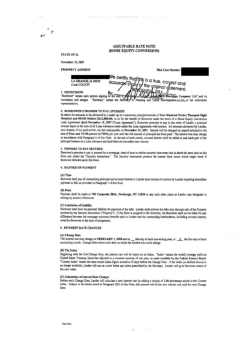

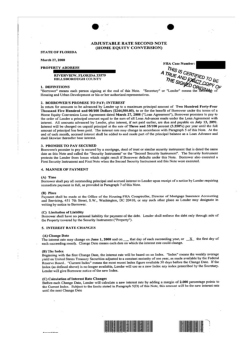

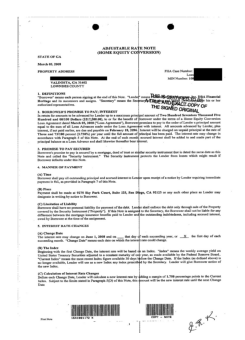

In [15]:
from PIL import Image
import  matplotlib.pyplot as plt

print("The following pages the lender's name was obscured:", bad_lender_page_nums)
for page in bad_lender_page_nums:
  image_file_path = page_df.loc[page]['image_file_paths']
  image = Image.open('.'+ image_file_path)
  plt.figure(figsize=(5,6))
  plt.axis('off')
  plt.imshow(image)
  plt.show()

### Exporting Extracted Data for Results of the Coding Challenge

In [16]:
results_df = page_df[['page_number','document_label','lender','maximum_principal_amount','maturity_date']]
results_df.to_csv('./data/coding_challenge_results_extracted_data.csv')

In [17]:
results_df.head()

,page_number,document_label,lender,maximum_principal_amount,maturity_date
0,0,first,EVERBANK REVERSE MORTGAGE,470250.0,2087-07-14
1,1,first,MORTGAGE SHOP,132750.0,2091-07-31
2,2,second,SECRETARY OF HOUSING,330000.0,2087-11-12
3,3,second,SECRETARY OF HOUSING,168000.0,2092-07-21
4,4,second,SECRETARY OF HOUSING,NaN,NaT


### Exporting Data to Use to Train the Spacy ML Classification Model

In [18]:
wrangled_doc_clf_data = page_df[['page_number', 'document_label', 'text']]
wrangled_doc_clf_data.to_csv('./data/wrangled_doc_clf_data.csv')